Example notebook that does stuff with the output files from a xspec, namely:
* the .txt from wdata that saves the data/model,
* the *.fits from writefits that save out the fit parameters.

IGH 14 Feb 2020 - Started

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.simplefilter('ignore')

# Some useful parameters
# norm = 1e-14/(4piD_A^2)*\int n_e n_p dV
# The norm factor from the XSPEC APEC model is defined here: https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node134.html
kev2mk=0.0861733
emfact=3.5557e-42

In [2]:
# An example file produced from writefits using FPMA and FPMA and a model of const*apec
hdumok = fits.open('mod_thf2prb.fits')
# hdumok.info()
mokprm=hdumok[1].data
mokcol=hdumok[1].columns.names
hdumok.close()
print(mokcol)

['DIRPATH', 'PHAFILE', 'BACKFILE', 'RESPFILE', 'ARFFILE', 'EXPOSURE', 'STATISTIC', 'kT2', 'EkT2', 'norm5', 'Enorm5', 'factor6', 'Efactor6', 'kT7', 'EkT7', 'Abundanc8', 'EAbundanc8', 'Redshift9', 'ERedshift9', 'norm10', 'Enorm10']


In [3]:
t1=mokprm['kt2'][0]/kev2mk
t1_cr=mokprm['ekt2'][0]/kev2mk
print('T1: ',t1,'MK, Err Rng: ',t1_cr)
em1=np.double(mokprm['norm5'][0])/emfact
em1_cr=np.double(mokprm['enorm5'][0])/emfact
print('EM1: ',em1,'cm^-3, Err Rng: ',em1_cr)
fac=mokprm['factor6'][0]
fac_cr=mokprm['efactor6'][0]
print('Fac: ',fac,' Fac Rng: ',fac_cr)

T1:  4.057312357339133 MK, Err Rng:  [4.0522065 4.0625744]
EM1:  4.862277469977783e+46 cm^-3, Err Rng:  [4.79379412e+46 4.93071116e+46]
Fac:  1.05385  Fac Rng:  [1.0454307 1.0623616]


In [4]:
# An example file produced from wdata from an iplot ldata ufspec delchi
dd=[]
with open('mod_thf2prb.txt', 'r') as f:
    lines = f.readlines()
    dd.append(lines)
# Get's rid of the first 3 lines which are normally not the data
dd=dd[0][3:]

In [5]:
# Different plots separated by 'NO NO NO NO NO\n' so need to find where this occurs
id_break=[i for i, value in enumerate(dd) if value == 'NO NO NO NO NO\n']

dd_ld=dd[:id_break[0]]
dd_uf=dd[id_break[0]+1:id_break[1]]
dd_dc=dd[id_break[1]+1:]

# For this example just assign the ldata plot
eng_ld=[]
deng_ld=[]
data_ld=[]
edata_ld=[]
mod_ld=[]
for i in dd_ld:
    temp_ld=i.split()
    eng_ld.append(float(temp_ld[0]))
    deng_ld.append(float(temp_ld[1]))
    data_ld.append(float(temp_ld[2]))
    edata_ld.append(float(temp_ld[3]))
    mod_ld.append(float(temp_ld[4]))


In [6]:
# Setup the font used for plotting
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.size'] = 18

# Latex in matplotlib still looks off if using Arial/Helvetica for main text
# The following change at least removes dejavusans.....
params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
plt.rcParams.update(params)

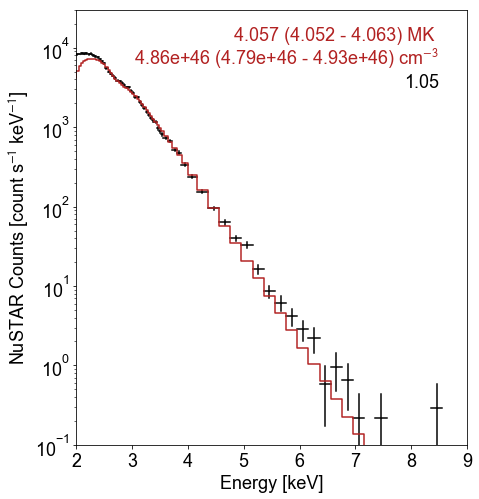

In [7]:
fig=plt.figure(figsize=(7,8))
plt.semilogy(eng_ld,data_ld,'.',ms=0.5,color='k')

for i in np.arange(len(data_ld)):
    plt.plot([eng_ld[i],eng_ld[i]],[data_ld[i]-edata_ld[i],data_ld[i]+edata_ld[i]],color='k')
    plt.plot([eng_ld[i]-deng_ld[i],eng_ld[i]+deng_ld[i]],[data_ld[i],data_ld[i]],color='k')
plt.plot(eng_ld,mod_ld,color='firebrick',drawstyle='steps-mid')

# param_label="{0:5.2f} MK, {1:5.2e} cm^-3".format(t1,em1)
param_labelt="{0:5.3f} ({1:5.3f} - {2:5.3f}) MK ".format(t1,t1_cr[0],t1_cr[1])
param_labelem="{0:5.2e} ({1:5.2e} - {2:5.2e}) cm".format(em1,em1_cr[0],em1_cr[1])+"$^{-3}$"

plt.text(8.5,10**(4.1),param_labelt,color='firebrick',ha='right')
plt.text(8.5,10**(3.8),param_labelem,color='firebrick',ha='right')
plt.text(8.5,10**(3.5),"{0:4.2f}".format(fac),color='k',ha='right')

plt.xlabel('Energy [keV]')
plt.ylabel('NuSTAR Counts [count s$^{-1}$ keV$^{-1}$]')
plt.ylim([1e-1,3e4])
plt.xlim([2,9])
plt.show()
    